In [2]:
pip install torch

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 20.1 MB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.2 MB/s eta 0:00:0031m20.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 10.0 MB/s eta 0:00:00
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torch]━━━━━ 3/4 [torch]kx]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [17]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

train_data_processed = []
for idx in range(1, 5):
    train_data = pd.read_csv(rf"train_FD00{idx}.txt",sep=" ",header=None)
    train_data.drop(columns=[26,27],inplace=True)

    train_data.columns = columns
    train_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
    train_data['RUL'] =  train_data['time_in_cycles'] / train_data.groupby('unit_number')['time_in_cycles'].transform('max') 

    train_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)

    train_data_processed.append(train_data)
    print(f"Processed train_FD00{idx}.txt, number of rows: {train_data.shape[0]}")
train_data_processed = pd.concat(train_data_processed, ignore_index=True)

Processed train_FD001.txt, number of rows: 20631
Processed train_FD002.txt, number of rows: 53759
Processed train_FD003.txt, number of rows: 24720
Processed train_FD004.txt, number of rows: 61249


Processed test_FD001.txt, number of rows: 13096
Processed test_FD002.txt, number of rows: 33991
Processed test_FD003.txt, number of rows: 16596
Processed test_FD004.txt, number of rows: 41214


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 1. Dataset class
class RULDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe.drop(columns=["RUL"]).values.astype(np.float32)
        self.y = dataframe["RUL"].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# 2. Neural Network model
class RULModel(nn.Module):
    def __init__(self, input_dim):
        super(RULModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)



In [8]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = train_data_processed.drop(columns=['RUL'])
scaled_features = scaler.fit_transform(features)
train_data_processed.loc[:, features.columns] = scaled_features

# Normalize test data using the same scaler
test_features = test_data_processed.drop(columns=['RUL'])
test_scaled_features = scaler.transform(test_features)
test_data_processed.loc[:, test_features.columns] = test_scaled_features

/var/folders/x_/hqwh_ynx1h16qy17vgc469740000gn/T/ipykernel_17761/1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46438155 -1.45241094 -1.44044032 ...  1.55221385  1.56418447
  1.57615508]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
/var/folders/x_/hqwh_ynx1h16qy17vgc469740000gn/T/ipykernel_17761/1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.00902172  1.00902172  0.94454996 ...  1.10572936 -0.76395171
 -0.89289524]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
/var/folders/x_/hqwh_ynx1h16qy17vgc469740000gn/T/ipykernel_17761/1275619669.py:11: FutureWarning: Setting an item of incompatible dtyp

In [9]:
# 4. Dataset & Dataloader
dataset = RULDataset(train_data_processed)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create TEST Dataset and DataLoader
test_dataset = RULDataset(test_data_processed)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Training Setup
input_dim = train_data_processed.shape[1] - 1  # Exclude RUL
model = RULModel(input_dim).to(device)

# ###########################################################Load the model if it exists
# model.load_state_dict(torch.load("rul_ann_model.pth"))
# model.to(device)
# model.eval()
# ##########################################################

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def evaluate_model(model, test_loader):
    # 3. Run inference
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # 4. Calculate MSE
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    mse = mean_squared_error(targets, preds)
    return mse

In [10]:
# 6. Training Loop
best_mse = float("inf")
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_mse = evaluate_model(model, test_loader)
    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "rul_ann_model.pth")

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}, Test MSE: {val_mse:.4f}")

Epoch [1/20], Loss: 0.0081, Test MSE: 0.0056
Epoch [2/20], Loss: 0.0053, Test MSE: 0.0058
Epoch [3/20], Loss: 0.0051, Test MSE: 0.0057
Epoch [4/20], Loss: 0.0049, Test MSE: 0.0059
Epoch [5/20], Loss: 0.0049, Test MSE: 0.0058
Epoch [6/20], Loss: 0.0048, Test MSE: 0.0054
Epoch [7/20], Loss: 0.0047, Test MSE: 0.0050
Epoch [8/20], Loss: 0.0047, Test MSE: 0.0054
Epoch [9/20], Loss: 0.0046, Test MSE: 0.0053
Epoch [10/20], Loss: 0.0046, Test MSE: 0.0050
Epoch [11/20], Loss: 0.0046, Test MSE: 0.0052
Epoch [12/20], Loss: 0.0045, Test MSE: 0.0054
Epoch [13/20], Loss: 0.0045, Test MSE: 0.0050
Epoch [14/20], Loss: 0.0045, Test MSE: 0.0050
Epoch [15/20], Loss: 0.0045, Test MSE: 0.0051
Epoch [16/20], Loss: 0.0045, Test MSE: 0.0055
Epoch [17/20], Loss: 0.0045, Test MSE: 0.0051
Epoch [18/20], Loss: 0.0045, Test MSE: 0.0056
Epoch [19/20], Loss: 0.0044, Test MSE: 0.0051
Epoch [20/20], Loss: 0.0044, Test MSE: 0.0053


# Visualize Test Results

In [11]:

idx=1

test_data_rul = pd.read_csv(rf"RUL_FD00{idx}.txt",sep=" ",header=None)
test_data = pd.read_csv(rf"test_FD00{idx}.txt",sep=" ",header=None)


test_data.drop(columns=[26,27],inplace=True)
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
        'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

test_data.columns = columns
test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

eol = []
for un in test_data['unit_number'].unique():
    temp_data = test_data[test_data['unit_number'] == un]
    eol_temp = test_data_rul.iloc[un-1].values[0]
    eol_temp_list = [eol_temp for i in range(len(temp_data))]

    eol.extend(eol_temp_list)


test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol) 
# test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)




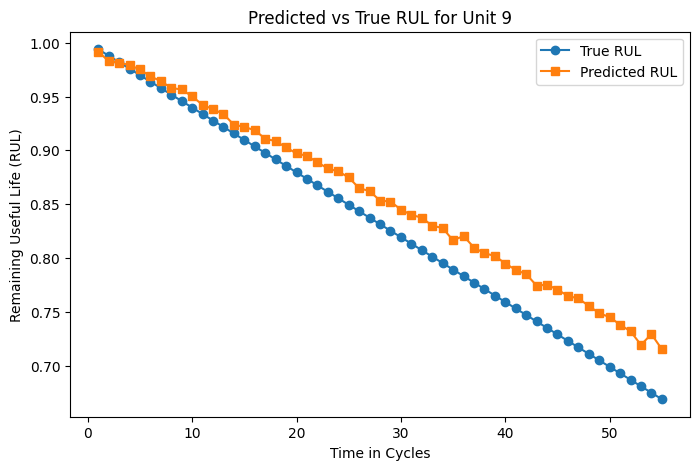

In [12]:
unit_id = 9  # Example unit number
unit_data = test_data[test_data['unit_number'] == unit_id]
true_rul = unit_data['RUL'].values


X_batch = scaler.transform(unit_data.drop(columns=['unit_number','setting_1','setting_2','RUL']))
X_batch = torch.tensor(X_batch).float().to(device)
model.eval()
with torch.no_grad():
    pred_rul = model(X_batch).cpu().numpy().flatten()

plt.figure(figsize=(8, 5))
plt.plot(unit_data['time_in_cycles'], 1-true_rul, label='True RUL', marker='o')
plt.plot(unit_data['time_in_cycles'], 1-pred_rul, label='Predicted RUL', marker='s')
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Predicted vs True RUL for Unit {unit_id}')
plt.legend()
plt.show()

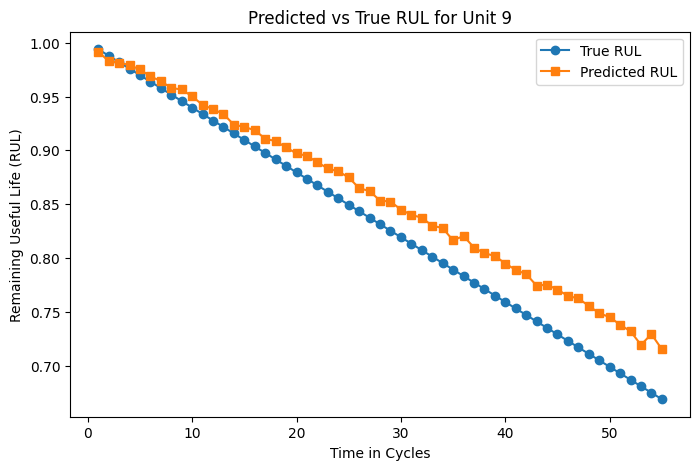

In [13]:
unit_id = 9  # Example unit number
unit_data = test_data[test_data['unit_number'] == unit_id]
true_rul = unit_data['RUL'].values


X_batch = scaler.transform(unit_data.drop(columns=['unit_number','setting_1','setting_2','RUL']))
X_batch = torch.tensor(X_batch).float().to(device)
model.eval()
with torch.no_grad():
    pred_rul = model(X_batch).cpu().numpy().flatten()

plt.figure(figsize=(8, 5))
plt.plot(unit_data['time_in_cycles'], 1-true_rul, label='True RUL', marker='o')
plt.plot(unit_data['time_in_cycles'], 1-pred_rul, label='Predicted RUL', marker='s')
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Predicted vs True RUL for Unit {unit_id}')
plt.legend()
plt.show()

In [14]:
import time
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- A. Predictive Performance (Accuracy) ---

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Model Performance ---")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R-squared (R²): {r2_rf:.4f}\n")


# --- B. Computational Efficiency (Speed & Size) ---

# a) Inference Time (Latency) for the entire test set
start_time = time.time()
rf_model.predict(X_test)
end_time = time.time()
total_time_rf = end_time - start_time
avg_inference_time_rf = (total_time_rf / len(X_test)) * 1000 # in milliseconds

print("--- Random Forest Model Efficiency ---")
print(f"Average Inference Time per Sample: {avg_inference_time_rf:.4f} ms")


# b) Model Size
joblib.dump(rf_model, "rf_model.joblib")
rf_model_size_mb = os.path.getsize("rf_model.joblib") / (1024 * 1024)
print(f"Model Size: {rf_model_size_mb:.2f} MB")

NameError: name 'rf_model' is not defined

In [16]:
# --- A. Predictive Performance (Accuracy) ---

# Set the model to evaluation mode
model.eval()  # Use 'model' instead of 'cnn_model'

y_true_list = []
y_pred_list = []

# Use the test_loader which has the properly scaled data
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch)  # Use 'model'
        
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(predictions.cpu().numpy())

# Combine results from all batches
y_true_ann = np.concatenate(y_true_list).flatten()
y_pred_ann = np.concatenate(y_pred_list).flatten()

# Calculate metrics
rmse_ann = np.sqrt(mean_squared_error(y_true_ann, y_pred_ann))
mae_ann = mean_absolute_error(y_true_ann, y_pred_ann)
r2_ann = r2_score(y_true_ann, y_pred_ann)

print("\n--- Neural Network Model Performance ---")
print(f"RMSE: {rmse_ann:.4f}")
print(f"MAE: {mae_ann:.4f}")
print(f"R-squared (R²): {r2_ann:.4f}\n")


# --- B. Computational Efficiency (Speed & Size) ---

print("--- Neural Network Model Efficiency ---")

# a) Inference Time (Latency) on a single batch
sample_batch, _ = next(iter(test_loader))
sample_batch = sample_batch.to(device)

start_time = time.time()
with torch.no_grad():
    model(sample_batch)  # Use 'model'
end_time = time.time()
inference_time_ann = (end_time - start_time) * 1000 # in milliseconds
print(f"Inference Time per Batch: {inference_time_ann:.2f} ms")


# b) Model Size (using the saved best model)
model_size_mb = os.path.getsize("rul_ann_model.pth") / (1024 * 1024)
print(f"Model Size: {model_size_mb:.2f} MB")


--- Neural Network Model Performance ---
RMSE: 0.0725
MAE: 0.0528
R-squared (R²): 0.9077

--- Neural Network Model Efficiency ---
Inference Time per Batch: 0.11 ms
Model Size: 0.52 MB
